# Analyzing the Incumbency Advantage

## Ekansh Vinaik, Matthew Chung

### Getting Started

Oftentimes in classes such as Government and Politics or U.S. History, students will learn about incumbency and how incumbent candidates are at great advantages over those who are new to the political scene in the area. The argument stems from increased funding and access to voters, along with a name brand recognition that only strengthens over time. In this notebook, we'll visualize the incumbency advantage and then make predictions using some machine learning algorithms on possible independent variables that we'll uncover in some future visualizations and analysis. The dataset we'll be using is the [State Election Results 1971-2012 dataset from Kaggle](https://www.kaggle.com/sohier/state-election-results-1971-2012). We'll start by importing some necessary modules.

In [17]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from statsmodels.stats.proportion import proportions_ztest

Let's load in the dataset and see how our data is formatted. We're skipping the **data collection** phase but we should be prepared to perform some **data wrangling**. You'll see below that we already start to do so by renaming the columns and by providing the types of each column to prevent Pandas from interpreting the wrong types (this is not always necessary, however our data has an issue with being interpreted automatically).

In [10]:
df = pd.read_csv('elections/states.csv', dtype={
    'state': str,
    'district': str,
    'year': int,
    'party': str,
    'incumbent': int,
    'dem': int,
    'gop': int,
    'other': int,
}, names=['state', 'district', 'year', 'party', 'incumbent', 'dem', 'gop', 'other'], skiprows=1)

df.head()

,state,district,year,party,incumbent,dem,gop,other
0,AK,1,1992,D,0,3019,3002,0
1,AK,2,1992,D,1,4704,2169,0
2,AK,3,1992,D,1,5210,2233,0
3,AK,4,1992,R,1,1754,4538,294
4,AK,5,1992,D,1,3953,0,1153


### Data Wrangling

Having loaded in the dataset, we immediately notice a few things. First, as you can see in the table, incumbency is measured as 1 or 0 instead of True or False. Let's fix that to make it clearer for us, though our packages will not have a problem with either representation.

In [11]:
df['incumbent'] = df['incumbent'].apply(lambda x: x == 1)

Second, though it is not in the table above, there are values in party that are not D or R. We'll treat these as extraneous as we're mostly focused on incumbency with political parties as a second thought.

In [12]:
df = df[(df.party == 'D') | (df.party == 'R')]

Finally, we'll drop the other column as political party is a forethought, and then we'll sum the Democratic and GOP voter counts into a total column.

In [13]:
df = df.drop('other', axis=1).dropna()
df['total'] = df[['dem', 'gop']].sum(axis=1)

Let's view our dataframe now to see if it looks very different.

In [14]:
df.head()

,state,district,year,party,incumbent,dem,gop,total
0,AK,1,1992,D,False,3019,3002,6021
1,AK,2,1992,D,True,4704,2169,6873
2,AK,3,1992,D,True,5210,2233,7443
3,AK,4,1992,R,True,1754,4538,6292
4,AK,5,1992,D,True,3953,0,3953


In this next step, we'll predict that we won't be looking at raw counts for some step of this process, and so we'll create a new dataframe that holds the ratios of Democratic to GOP voter counts by year. We'll group by year and sum each column, dividing it by the total, to find each year's ratio.

In [16]:
years = df.groupby(['year'])
ratios = pd.DataFrame()
ratios['dem'] = years.sum()['dem'] / years.sum()['total']
ratios['gop'] = years.sum()['gop'] / years.sum()['total']
ratios = ratios.reset_index()
ratios.head()

,year,dem,gop
0,1971,0.583459,0.416541
1,1972,0.509436,0.490564
2,1973,0.660898,0.339102
3,1974,0.574307,0.425693
4,1975,0.674162,0.325838


### Exploratory Data Analysis (EDA) / Data Visualization

The next step in the data analysis process is to perform some exploratory data analysis (EDA) to discover and unearth relationships or phenomena that are not always immediately obvious. Our dataset provides us with demographic information by political party, and so we'll first look to see if there are extraneous patterns within political party voting ratios that we must consider before we look at incumbency visualizations.

Below, we create two plots. The first only shows 4 year election cycles, and the second shows 2 year election cycles. These coincide with presidential and state elections, so we can see patterns when the voting population is pushed to vote.

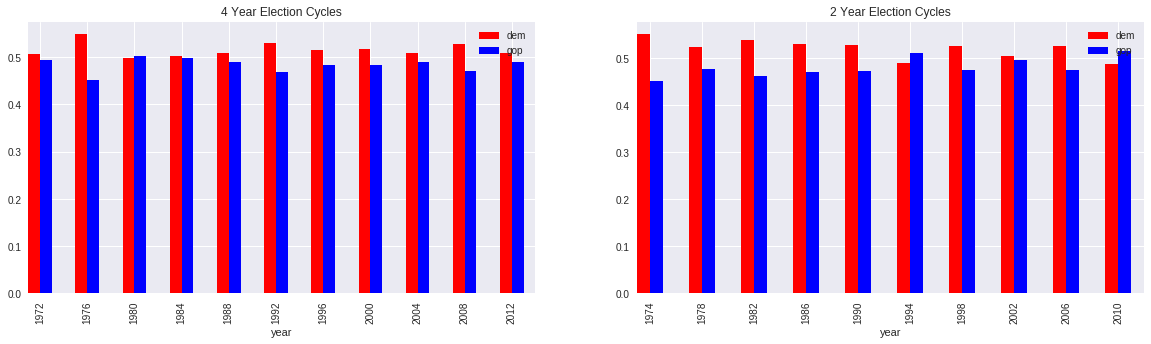

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

ratios[ratios.year % 4 == 0].plot.bar(
    x='year', y='dem', ax=axes[0], color='red', position=1, width=.25)
ratios[ratios.year % 4 == 0].plot.bar(
    x='year', y='gop', ax=axes[0], color='blue', title='4 Year Election Cycles', position=0, width=.25)
ratios[ratios.year % 4 == 2].plot.bar(
    x='year', y='dem', ax=axes[1], color='red', position=1, width=.25)
ratios[ratios.year % 4 == 2].plot.bar(
    x='year', y='gop', ax=axes[1], color='blue', title='2 Year Election Cycles', position=0, width=.25)
plt.show()

Our visualizations show some interesting insights into the data, however nothing is too extreme to consider as far as incumbency goes, at least as far as the visual representations go. We can see that the elections after Watergate had far higher turnouts of Democrats than Republicans, however over time this evens out to a more equal / less uneven ratio. Now, let's take a look at a chart of incumbent win ratios. First, we need to create a dataframe that actually holds these ratios, and thankfully Pandas has some builtin functions that will make this very simple for us.

In [ ]:
inc = df.groupby('year').incumbent.value_counts(normalize=True).to_frame()
inc.columns = ['ratio']
inc = inc.reset_index()
inc.head()

Next, let's plot these ratios over time to see the how the incumbency advantage has progressed over time.

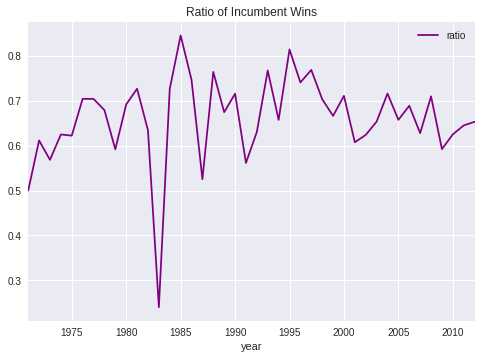

In [8]:
inc[inc.incumbent].plot.line(x='year', y='ratio', color='purple', title='Ratio of Incumbent Wins')
plt.show()

Looking at our chart above, we can see a strange drop between 1980-1985. However, aside from that year, the incumbent win ratio is clearly above 60% for nearly the entire range of years. Before we move on to some machine learning algorithms, let's verify our claim that the incumbent advantage is statistically significant. We'll perform a proportion z test with $ \alpha = .05 $ to determine if the incumbent ratio is statistically high.

In [41]:
count = df[df.incumbent].size
total = df.size
zscore, pval = proportions_ztest(count, total, 0)

display('Z-Score', zscore, 'P-Value', pval)

'Z-Score'

1325.4135573587923

'P-Value'

0.0

### Making Predictions with Machine Learning

Let's see what we can predict with some machine learning algorithms. We'll assume that our independent variables will be the state and year, and we'll determine what advantage an incumbent candidate might have. We can do this in a number of ways. First, let's start by performing some linear regression to see what results we can get out of the most simple model possible.

In [47]:
sm.ols(formula='incumbent ~ year + state', data=df).fit().params.head()

,0,1
Intercept,2.164159,-1.164159
state[T.AL],0.082895,-0.082895
state[T.AR],0.001588,-0.001588
state[T.CA],0.019500,-0.019500
state[T.CO],0.059159,-0.059159


Immediately, we notice a problem. The problem is binary classification in nature, and a linear regression model is inherently used for regression instead of classification. Thankfully, statsmodel converted our incumbency status into a numerical 0 and 1, however it does not make much sense to look at the model from this viewpoint. Instead, we can do one of two things: we can change our regression outcome to give us a ratio or we can move to a classification algorithm. Why not both?

In [52]:
sm.ols(formula='ratio ~ year', data=inc[inc.incumbent]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.013
Date:                Sat, 16 Dec 2017   Prob (F-statistic):              0.320
Time:                        17:41:10   Log-Likelihood:                 38.847
No. Observations:                  42   AIC:                            -73.69
Df Residuals:                      40   BIC:                            -70.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8483      2.493     -0.741      0.463      -6.886       3.190
year           0.0013      0.001      1.006      0.320      -0.001       0.004
==============================================================================
Omnibus:                       28.174   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.717
Skew:                          -1.588   Prob(JB):                     1.33e-17
Kurtosis:                       8.859   Cond. No.                     3.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Above, we see that the coefficient for the year as far as the incumbency ratio is very small. Additionally, the P value is far above our classic $ \alpha > 0.5 $, so we can actually exclude year from our analysis and only focus on a state. Now, let's look at how we can classify each state into an incumbent preference state or not. There does exist a possibility that every single state will give an advantage to incumbents, so we should be careful with our classification. To be clear, this is not a *machine learning* classification problem: we'll loop through each state and individually print out the ones that aren't advantageous to incumbents, assuming that these even exist.

In [58]:
alpha = .05
states = []

for state in df.state.unique():
    temp = df[df.state == state].drop(['state', 'district'], axis=1)
    count = temp[temp.incumbent].size
    total = temp.size
    zscore, pval = proportions_ztest(count, total, 0)

    if pval > alpha:
        states.append(state)

states

[]

As we predicted, there are literally no states that do not provide an incumbency advantage. 

### Conclusion / Policy Decision